Dans ce notebook, nous visualisons ce que voit EfficientNet <br>
https://www.analyticsvidhya.com/blog/2019/05/understanding-visualizing-neural-networks/

<p>
Objectifs
<p>
1) Finir les modifs en cours, les push sur Git et prévenir Cédric <br>
2) Voir si on arrive à visualiser ce que voit un neurone (cf video avant) <br>
3) Si ça marche, esasyer de récupérer la valeur d'activation de chaque neurone sur différents groupes d'images (jeunes, vieux, hommes femmes...) et identifier les neurones répondant à certains groupes puis visualiser ce qu'il voient <br>
4) Eventuellement si possible, utiliser EfficientNet sur un autre dataset avec une tache simpple (e.g. classificaiton) et comparer les performances du modèle brut avec celles du modèle sans les neurones "éthiques" <br>
5) Alternativement, si on arrive pas à faire tout ça : entrainer EfficientNet sur de la détection de visage en trouvant un dataset open source adapté puis comparer les perf du modèle sur des images qu'on aura labelisées à la main comme homme, "femme", "jeune"...

In [1]:
import efficientnet.keras as efn 
from ethicnet import config
from ethicnet import visualization
from ethicnet import preprocessing
import matplotlib.pyplot as plt
import matplotlib.image

# Import du modèle

In [2]:
model = efn.EfficientNetB0(include_top=False, weights="imagenet")

In [3]:
model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________

# Définition des couches intéressantes

In [4]:
# defining names of layers from which we will take the output
layer_names = ['stem_conv', 'block1a_project_conv','block2a_project_conv','block3a_project_conv','block4a_project_conv','block5a_project_conv','block6a_project_conv','block7a_project_conv','top_conv']

# layer_names_activation = ['stem_activation','block1a_activation','block2a_expand_activation'] 

# Visualisation d'une image

(1, 200, 200, 3)


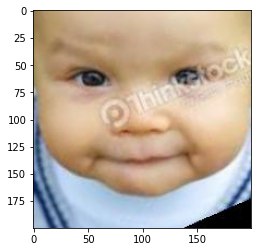

In [5]:
image = matplotlib.image.imread(config.data_dir +'1_0_0_20161219140623097.jpg.chip.jpg')
plt.imshow(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
print(image.shape)

Ce que voit une certaine couche de EfficientNet :

In [6]:
output = preprocessing.output_of_layer_for_one_image('block1a_project_conv',model,image)

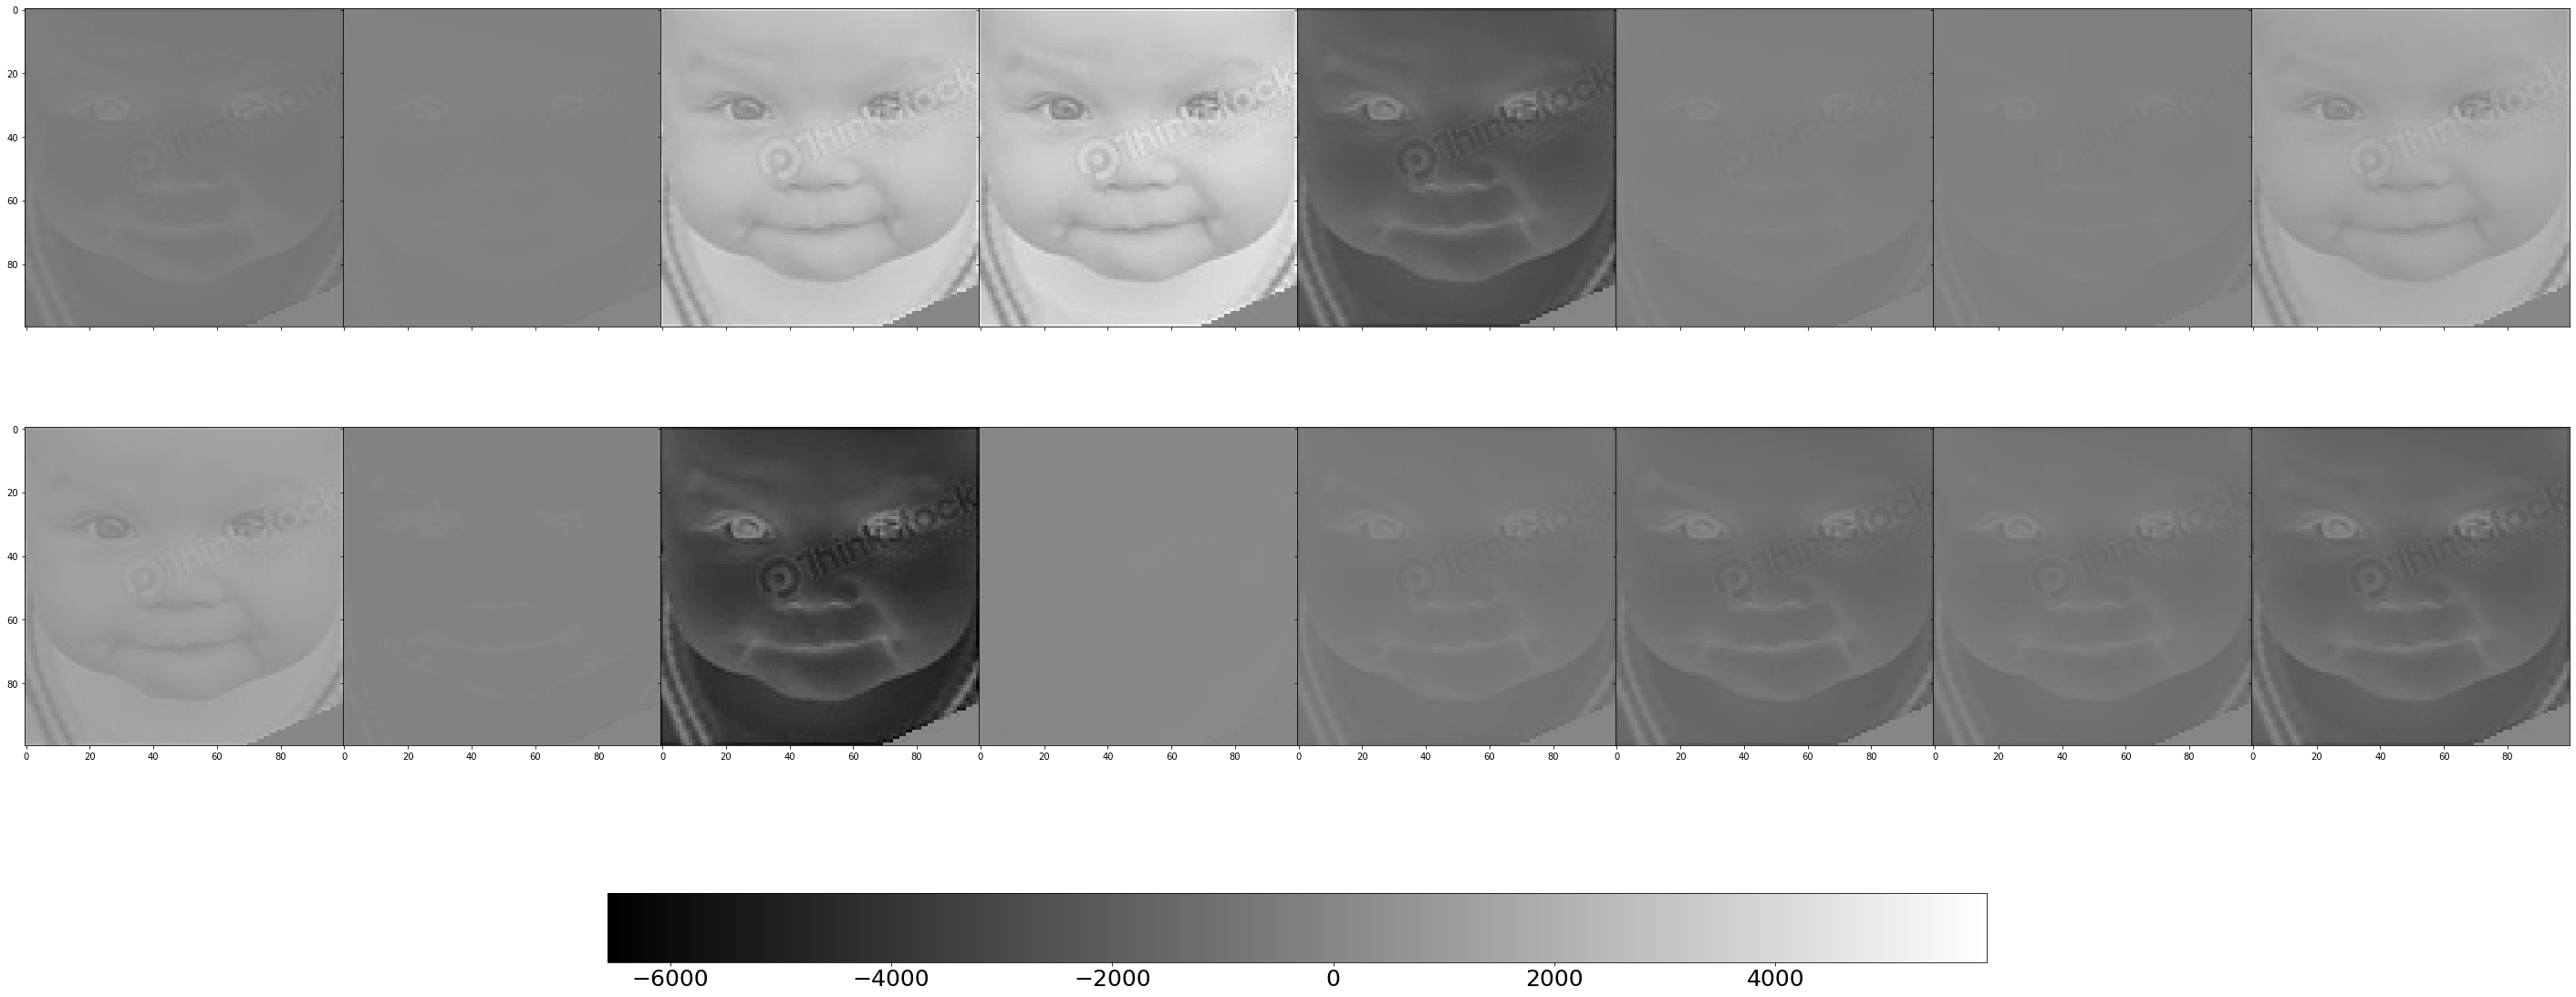

In [7]:
visualization.plot_layer_from_output(output)

Une autre couche :

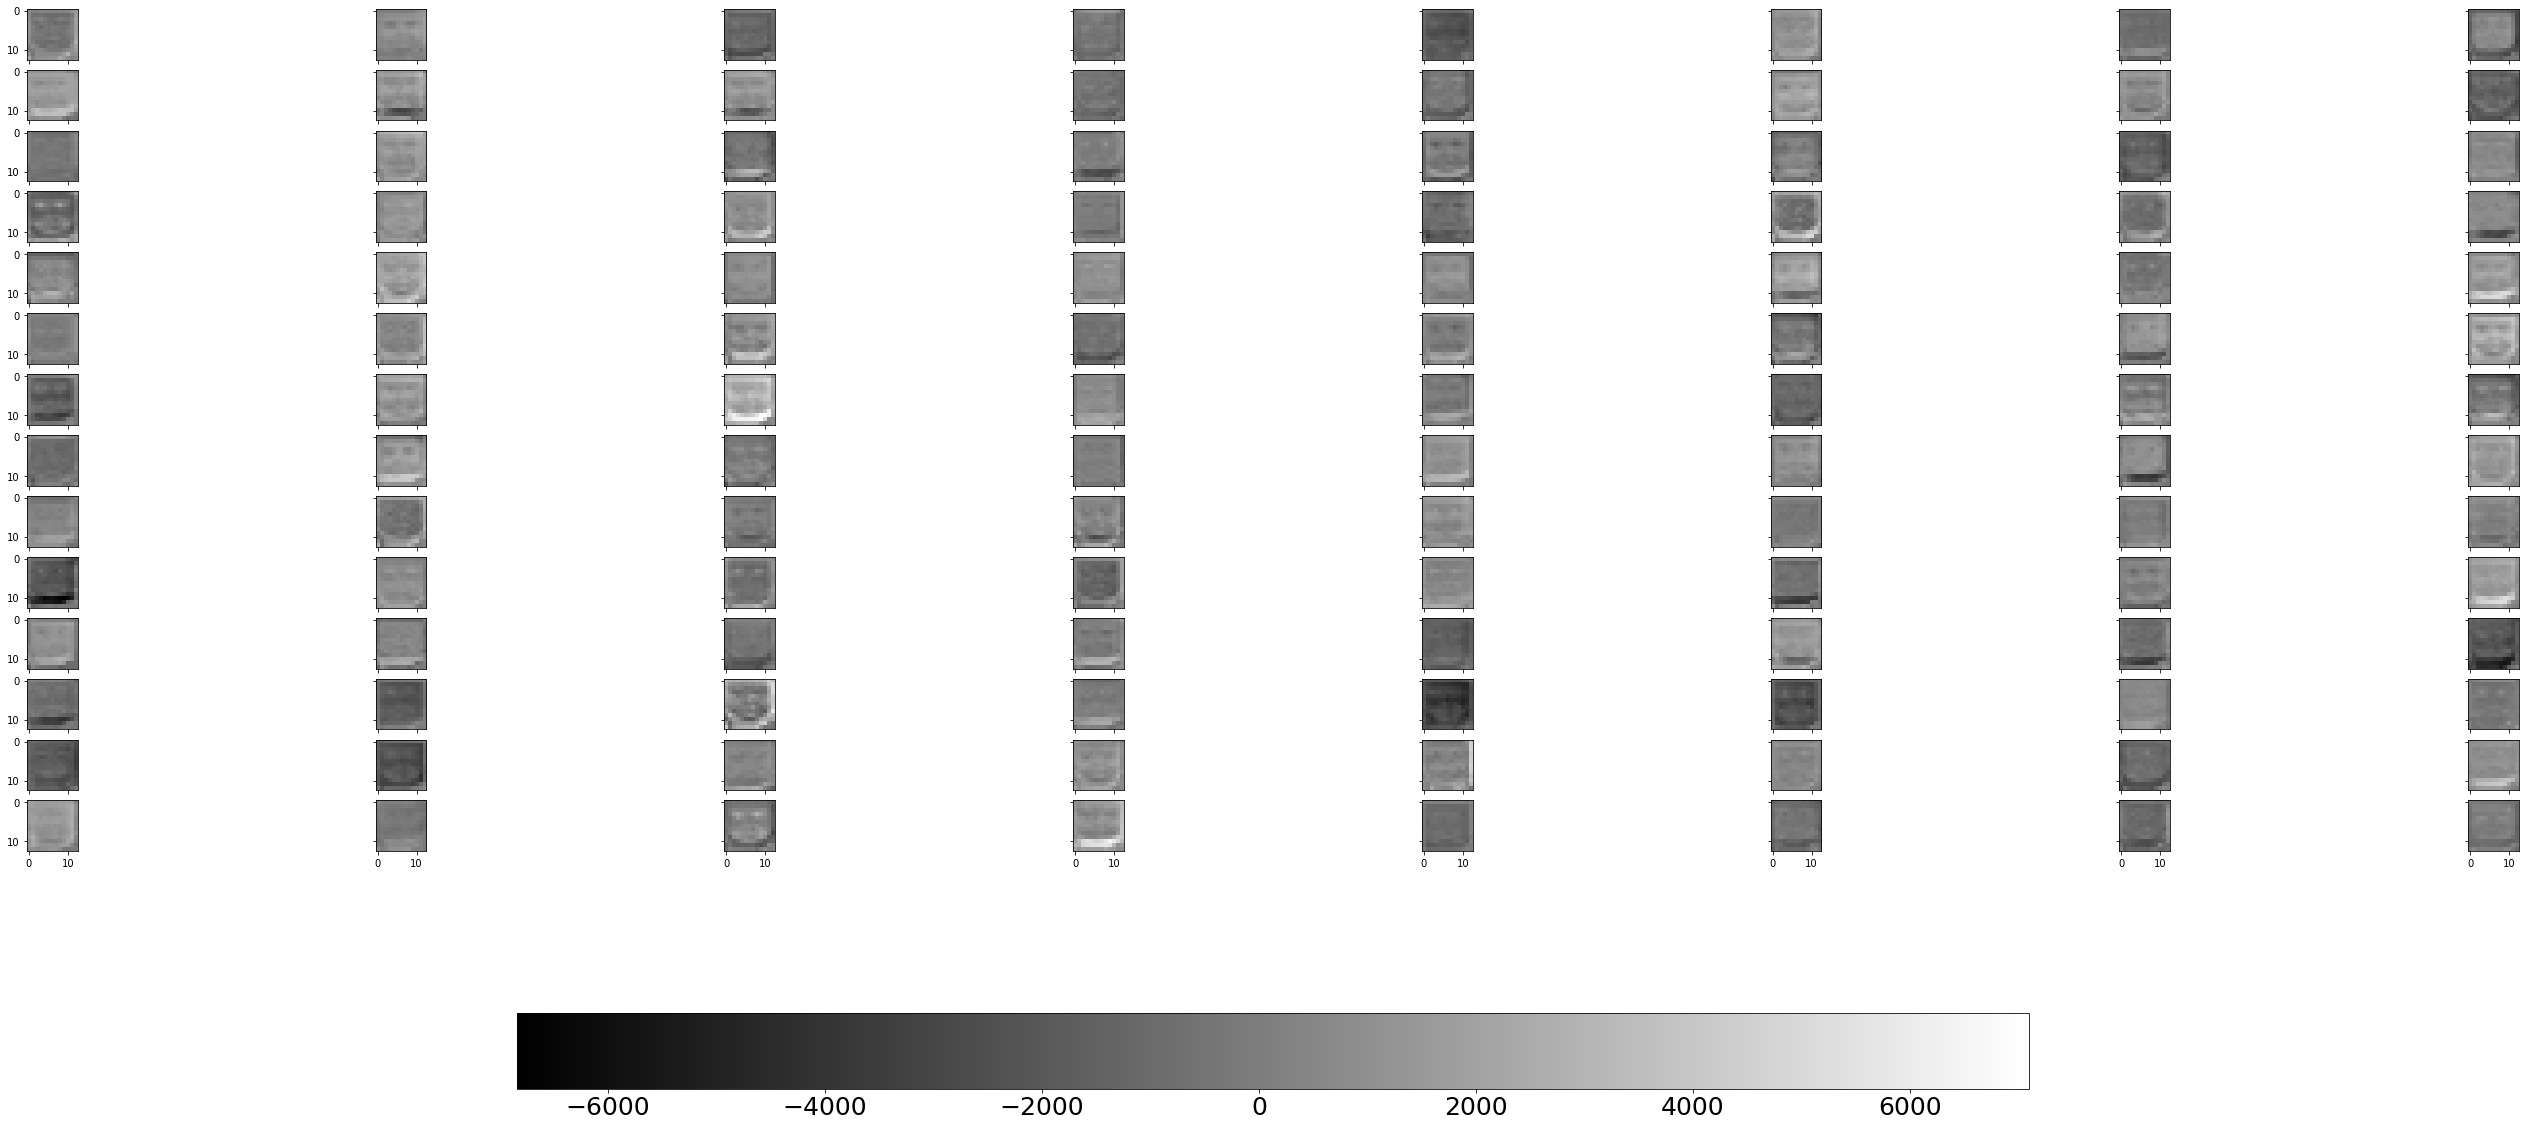

In [8]:
visualization.plot_layer_from_output(preprocessing.output_of_layer_for_one_image(layer_names[5],model,image))

# Combinaison de deux images

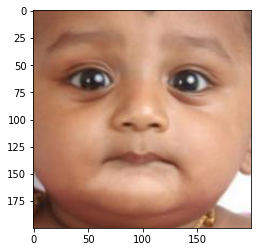

In [9]:
image1 = matplotlib.image.imread(config.data_dir +'1_1_3_20161220220548777.jpg.chip.jpg')
plt.imshow(image1)
image1 = image1.reshape((1, image1.shape[0], image1.shape[1], image1.shape[2]))

Ajoutons ce bébé au précédent, et regardons la moyenne de ce que EfficientNet voit

In [10]:
output_two_images = preprocessing.output_of_layer_for_multiple_images(layer_names[1],model,[image,image1])

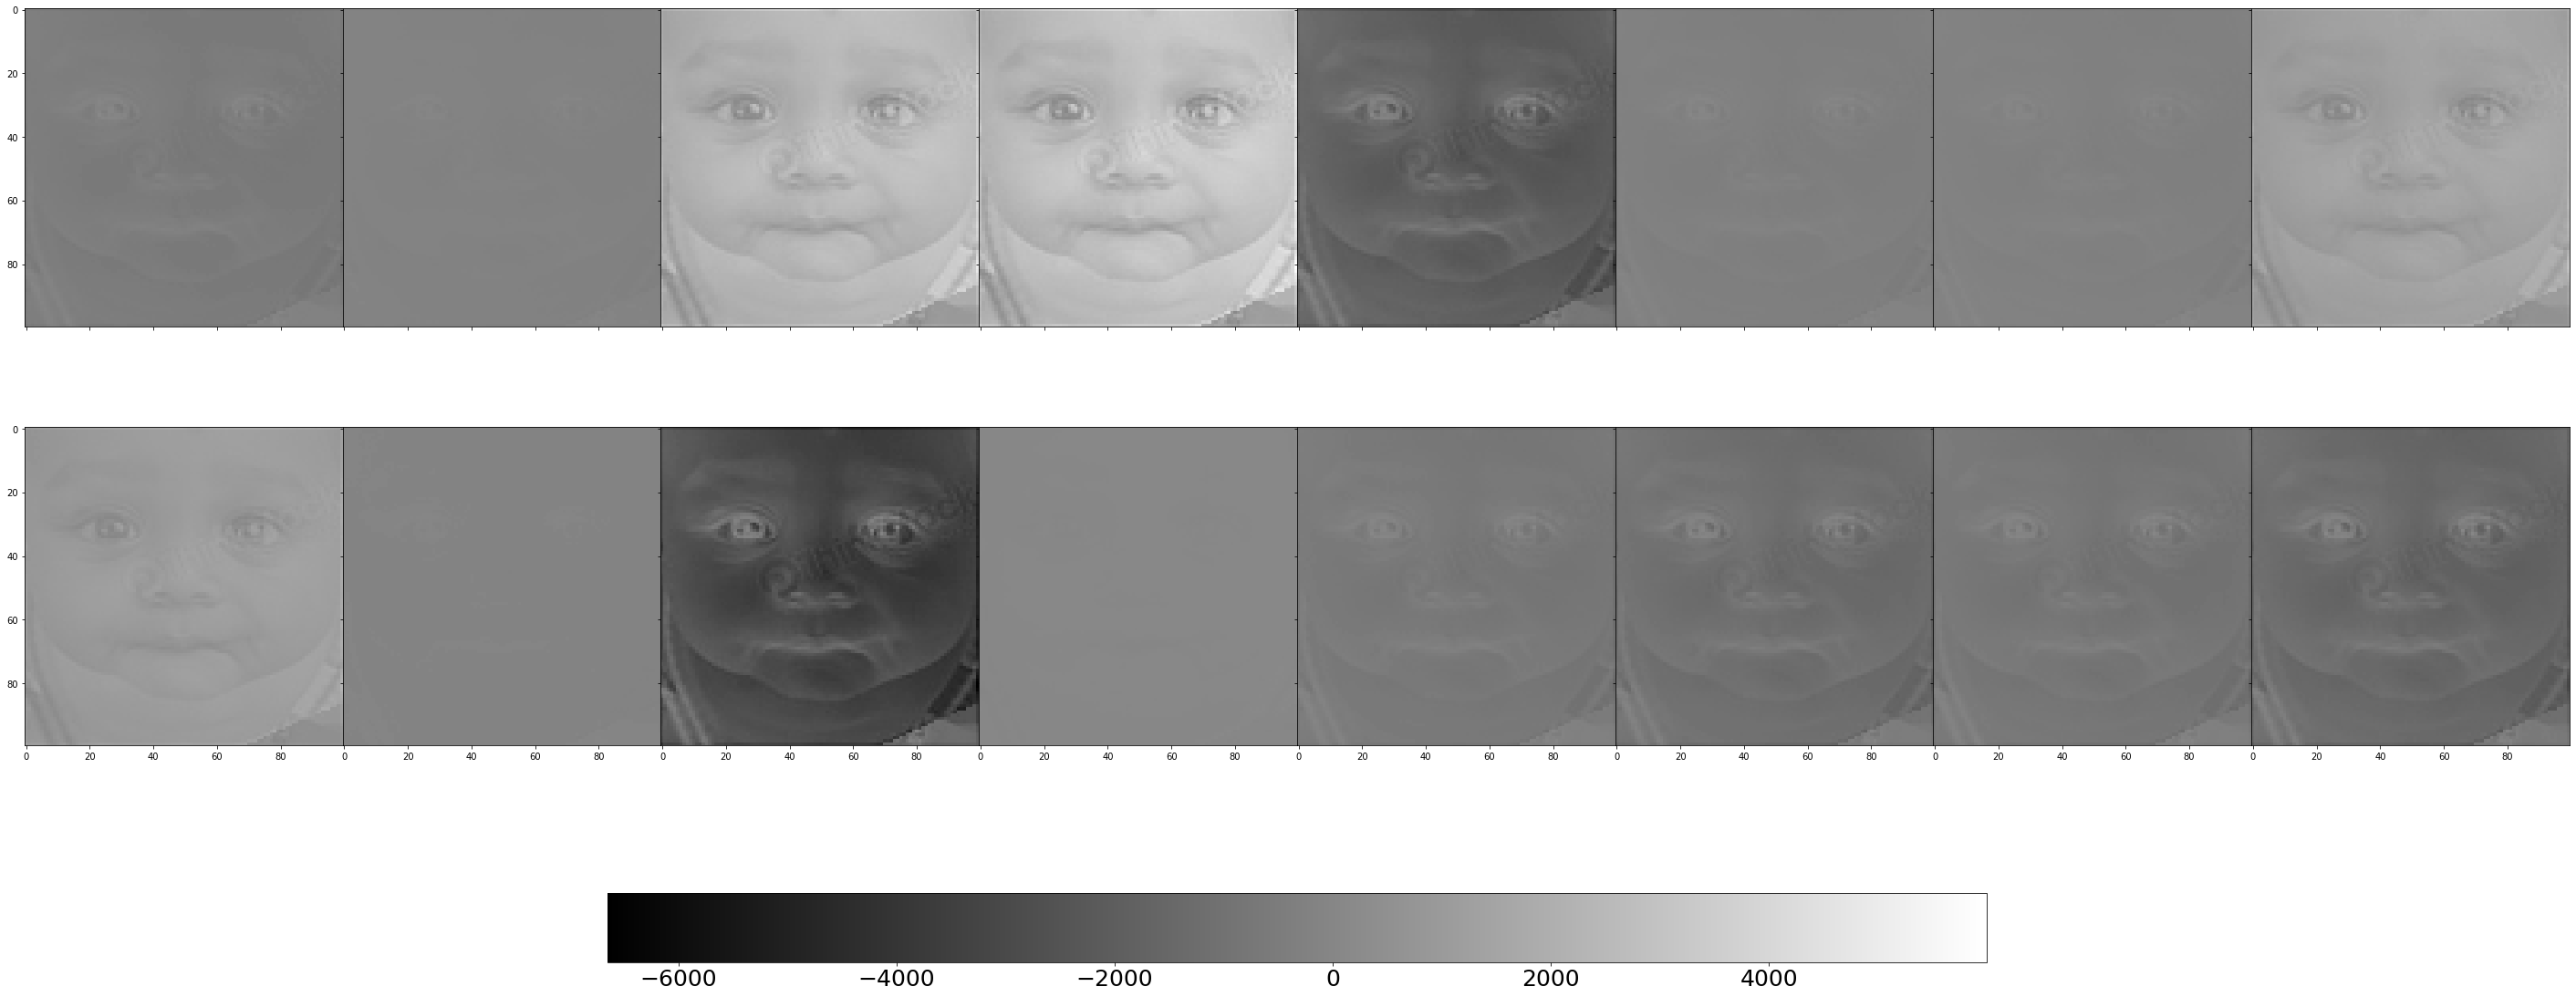

In [11]:
visualization.plot_layer_from_output(output_two_images)

# Groupons les personnes similaires

Importons notre dataframe

In [12]:
df = preprocessing.extract_infos_from_images_name()
preprocessing.correct_undefined_ethnicity(df)
df.head()

image_name  age     sex ethnicity
0  33_0_1_20170113134141083.jpg.chip.jpg   33    male     black
1  33_0_3_20170119150501686.jpg.chip.jpg   33    male    indian
2  35_0_2_20170117135233576.jpg.chip.jpg   35    male     asian
3  42_0_3_20170119204253127.jpg.chip.jpg   42    male    indian
4  28_1_3_20170109141400528.jpg.chip.jpg   28  female    indian

<p>
Pour les âges, on va définir 5 catégories :
<p>
bébé : 0-4 ans <br>
enfants : 5-15 ans <br>
jeunes : 16-30 ans <br>
adultes : 31-60 ans <br>
vieux : 61+ ans <br>

In [13]:
df['age_category'] = df.apply(preprocessing.categorize_age, axis=1)
df.drop(columns = 'age',inplace=True)
df.rename(columns={'age_category':'age'}, inplace=True)
df.head()

image_name     sex ethnicity    age
0  33_0_1_20170113134141083.jpg.chip.jpg    male     black  adult
1  33_0_3_20170119150501686.jpg.chip.jpg    male    indian  adult
2  35_0_2_20170117135233576.jpg.chip.jpg    male     asian  adult
3  42_0_3_20170119204253127.jpg.chip.jpg    male    indian  adult
4  28_1_3_20170109141400528.jpg.chip.jpg  female    indian  young

Groupons les lignes correspondant aux personnes similaires dans des dataframes

In [14]:
d = preprocessing.dictionnary_from_dataframe(df)

Exemple : Les bébés garçons noirs

In [15]:
d['male_black_baby'].head()

image_name   sex ethnicity   age
602   1_0_1_20170112211228948.jpg.chip.jpg  male     black  baby
672   1_0_1_20170110213645409.jpg.chip.jpg  male     black  baby
822   4_0_1_20161219230428976.jpg.chip.jpg  male     black  baby
1060  4_0_1_20170110213311678.jpg.chip.jpg  male     black  baby
3380  3_0_1_20170110213755346.jpg.chip.jpg  male     black  baby

On combine toutes les images de bébé garçon noir

In [16]:
images_male_black_baby = preprocessing.images_of_a_category('male','black','baby',d)

Voici, en moyenne, ce que voit la première couche de EfficientNet pour les bébés garçons noirs :

In [17]:
layer = 'stem_activation'

In [18]:
output_male_black_baby = preprocessing.output_of_layer_for_multiple_images(layer,model,images_male_black_baby)

In [19]:
output_male_black_baby.shape

(1, 100, 100, 32)

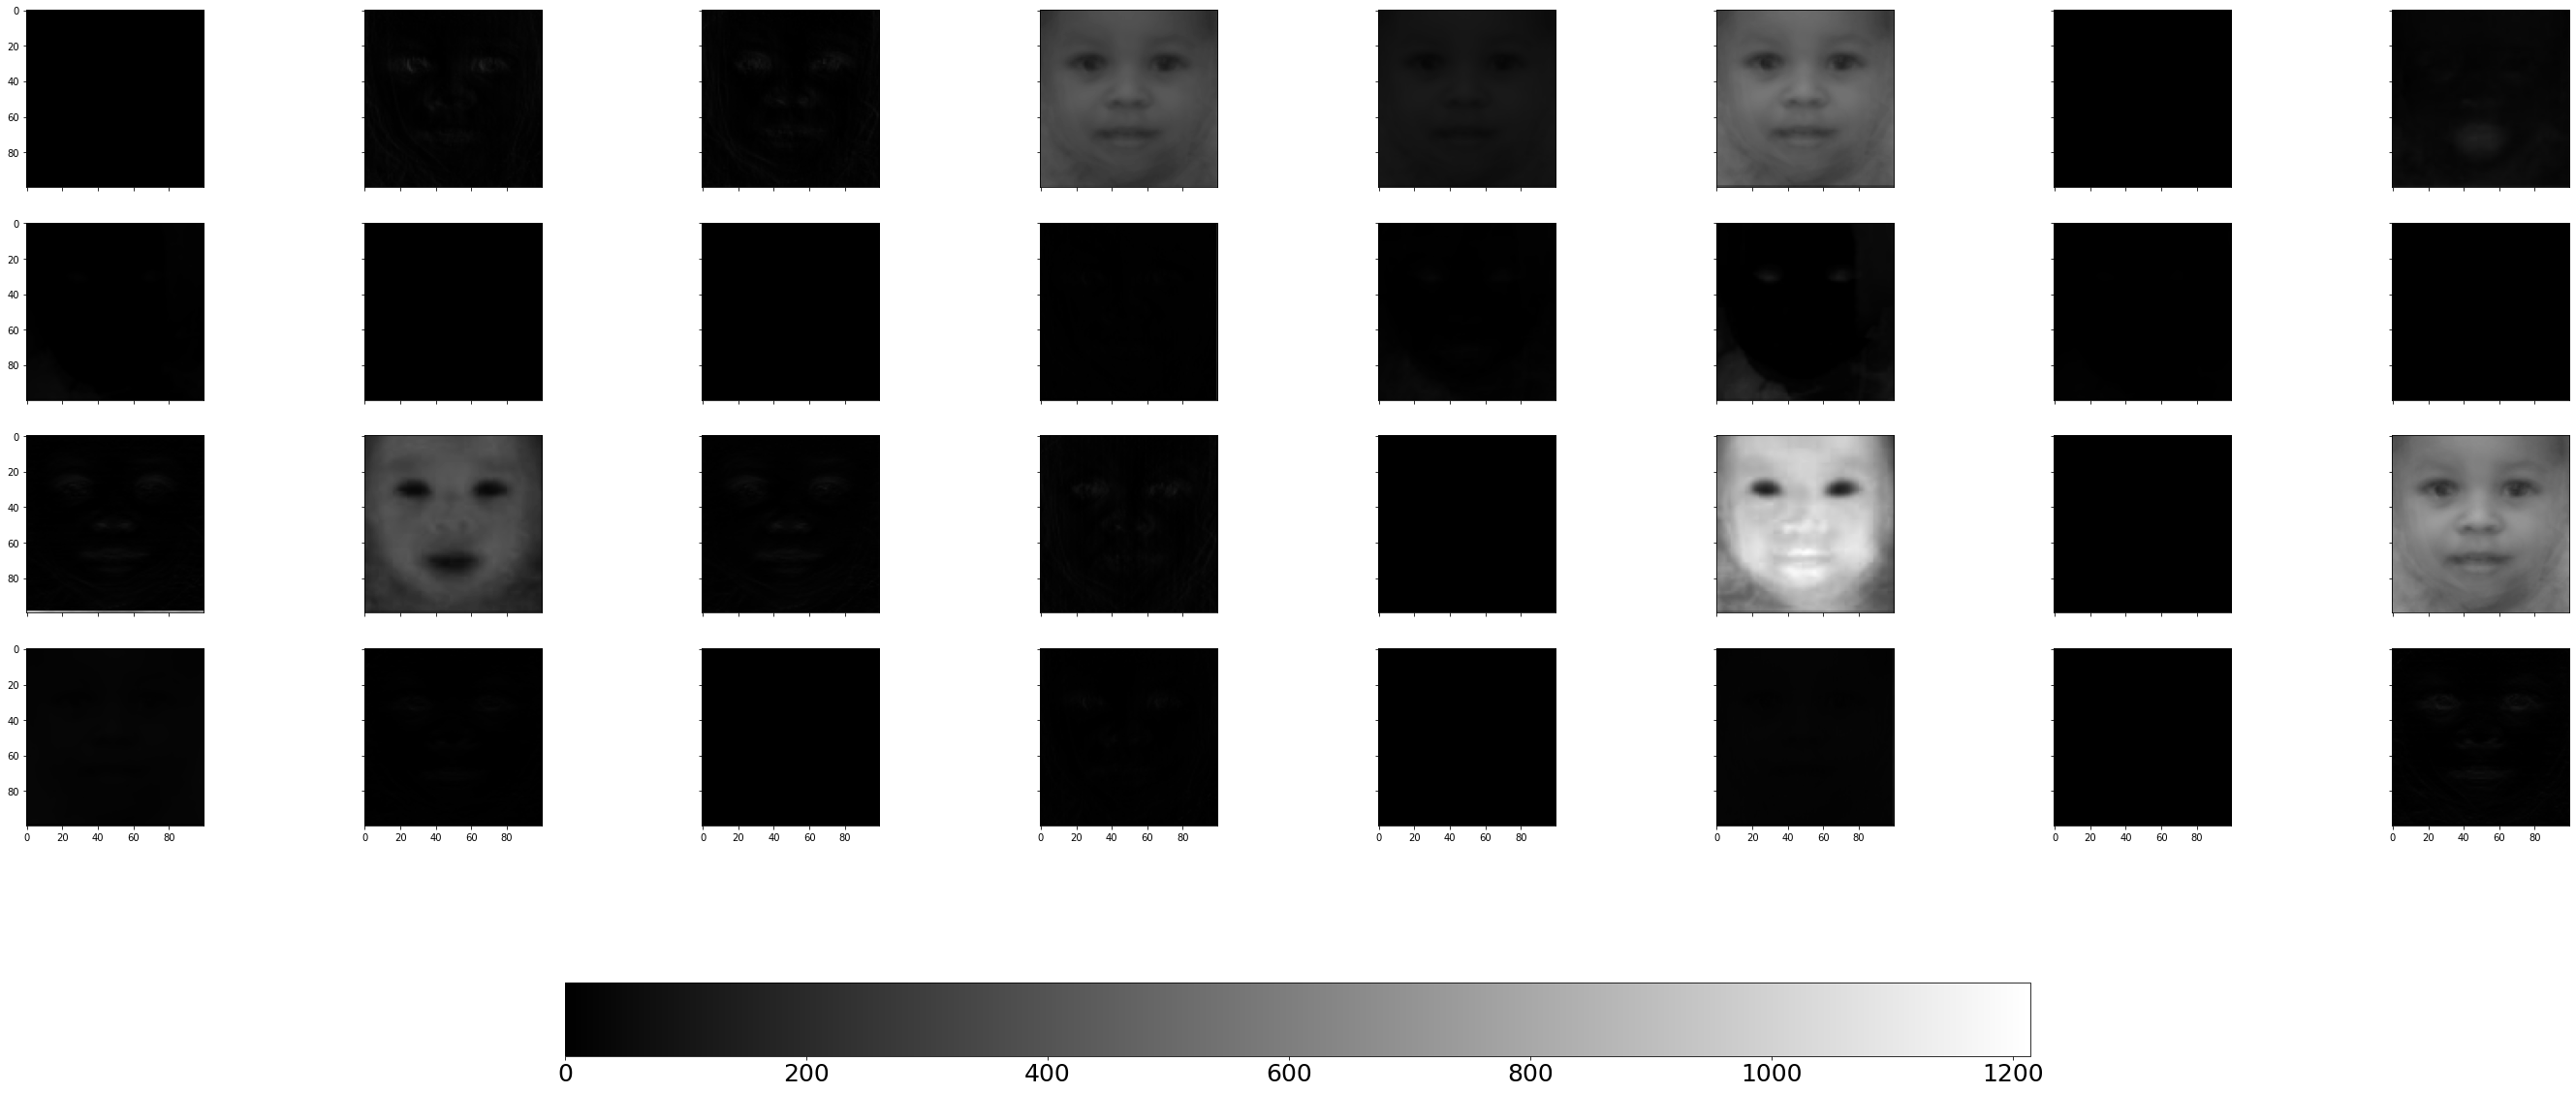

In [20]:
visualization.plot_layer_from_output(output_male_black_baby)

Pour les jeunes femmes blanches :

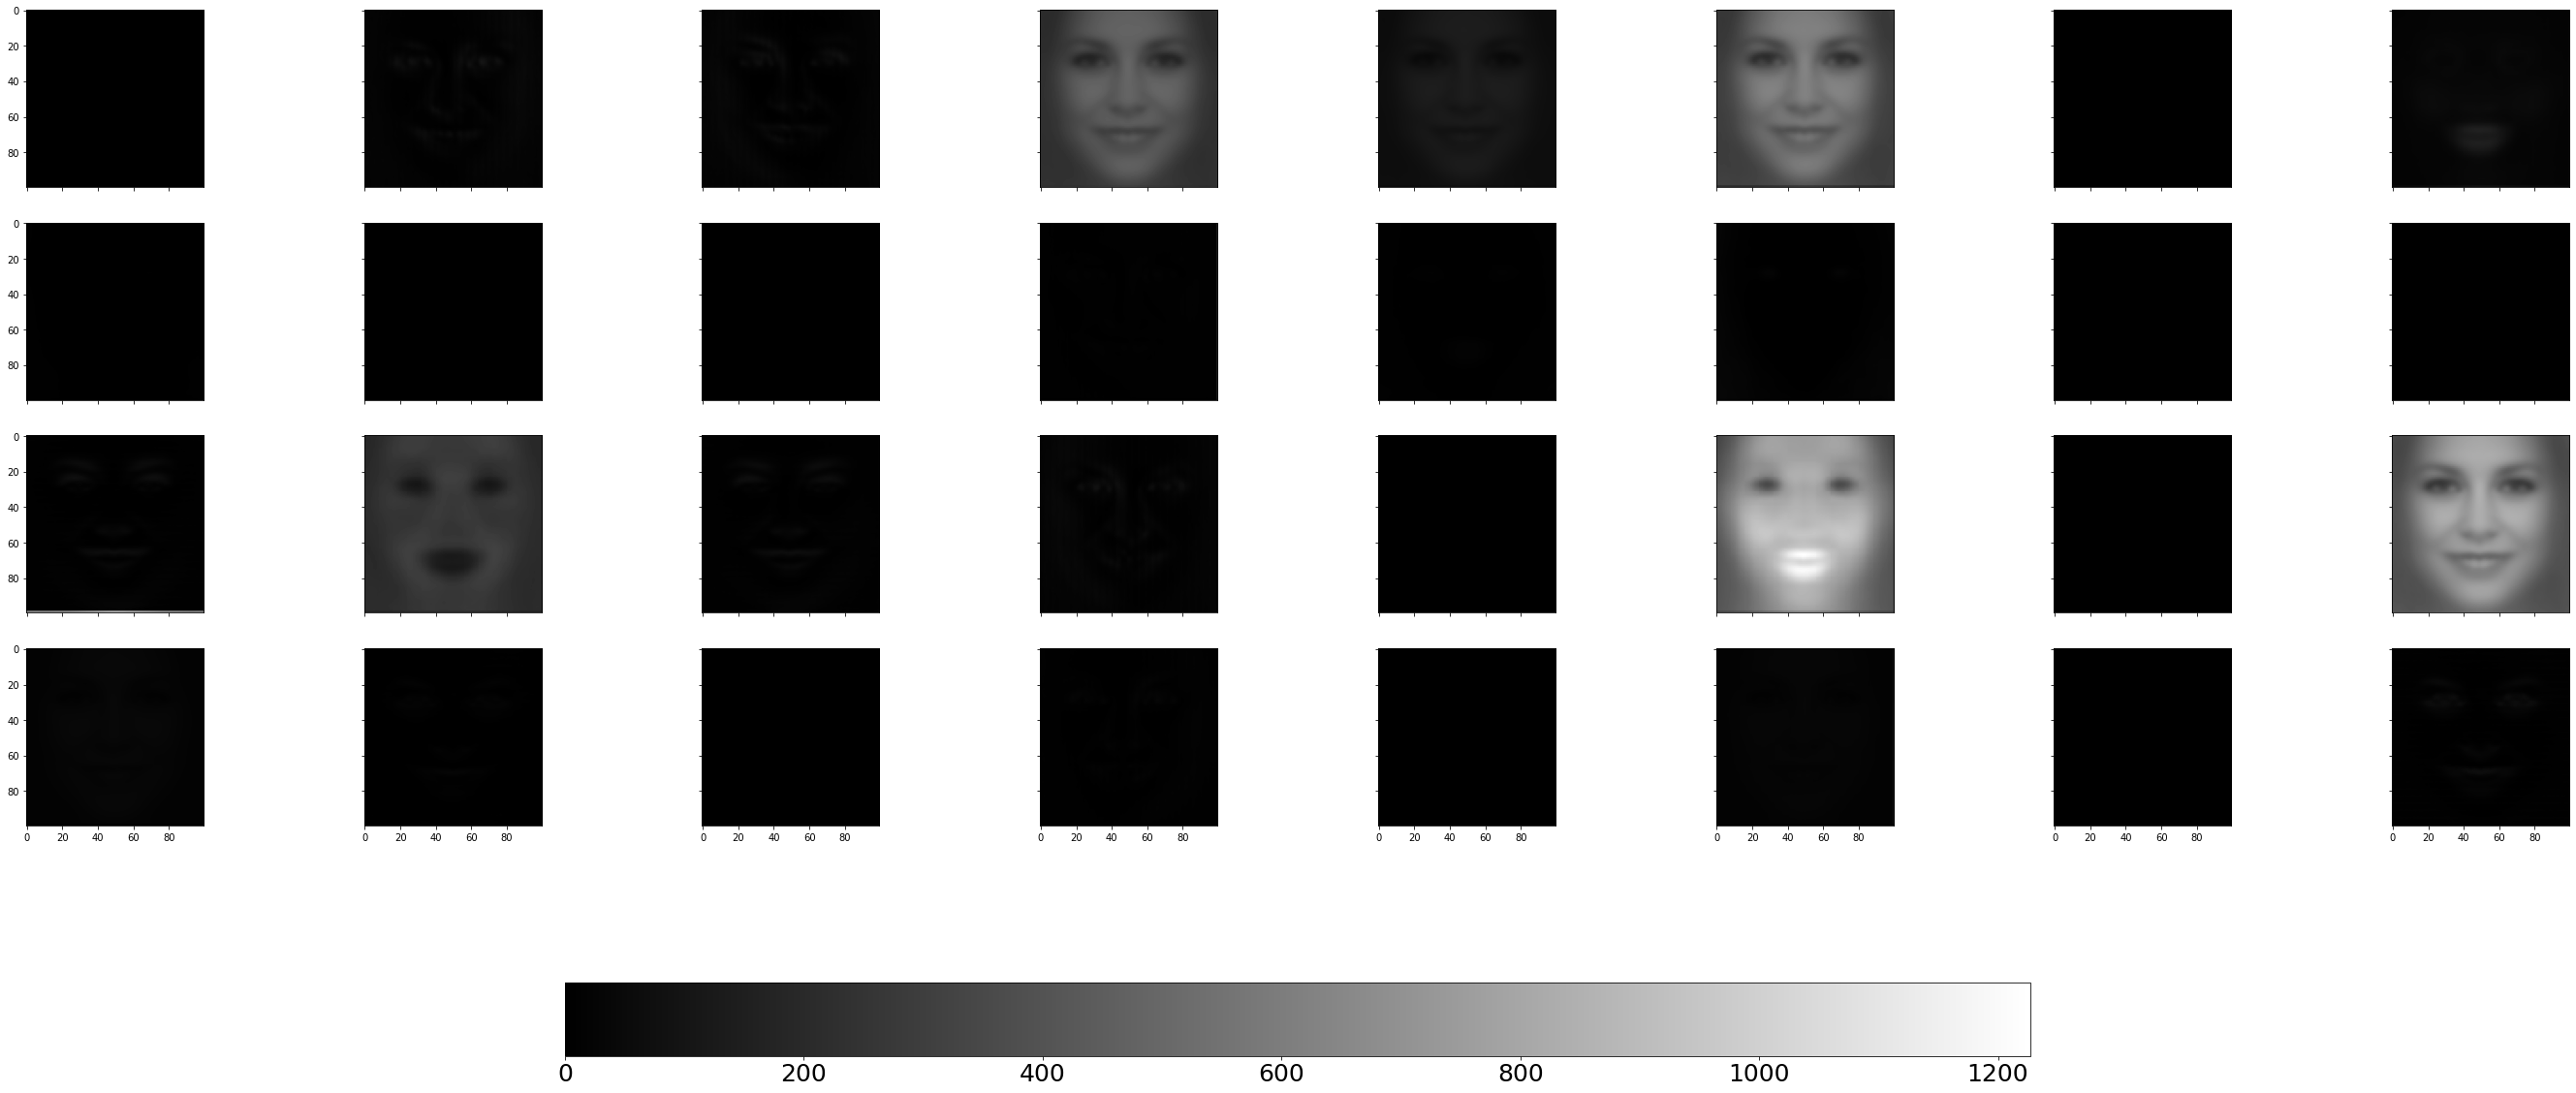

In [21]:
visualization.plot_layer_from_output(preprocessing.output_of_layer_for_multiple_images(layer,model,preprocessing.images_of_a_category('female','white','young',d)))

Pour les femmes âgées indiennes :

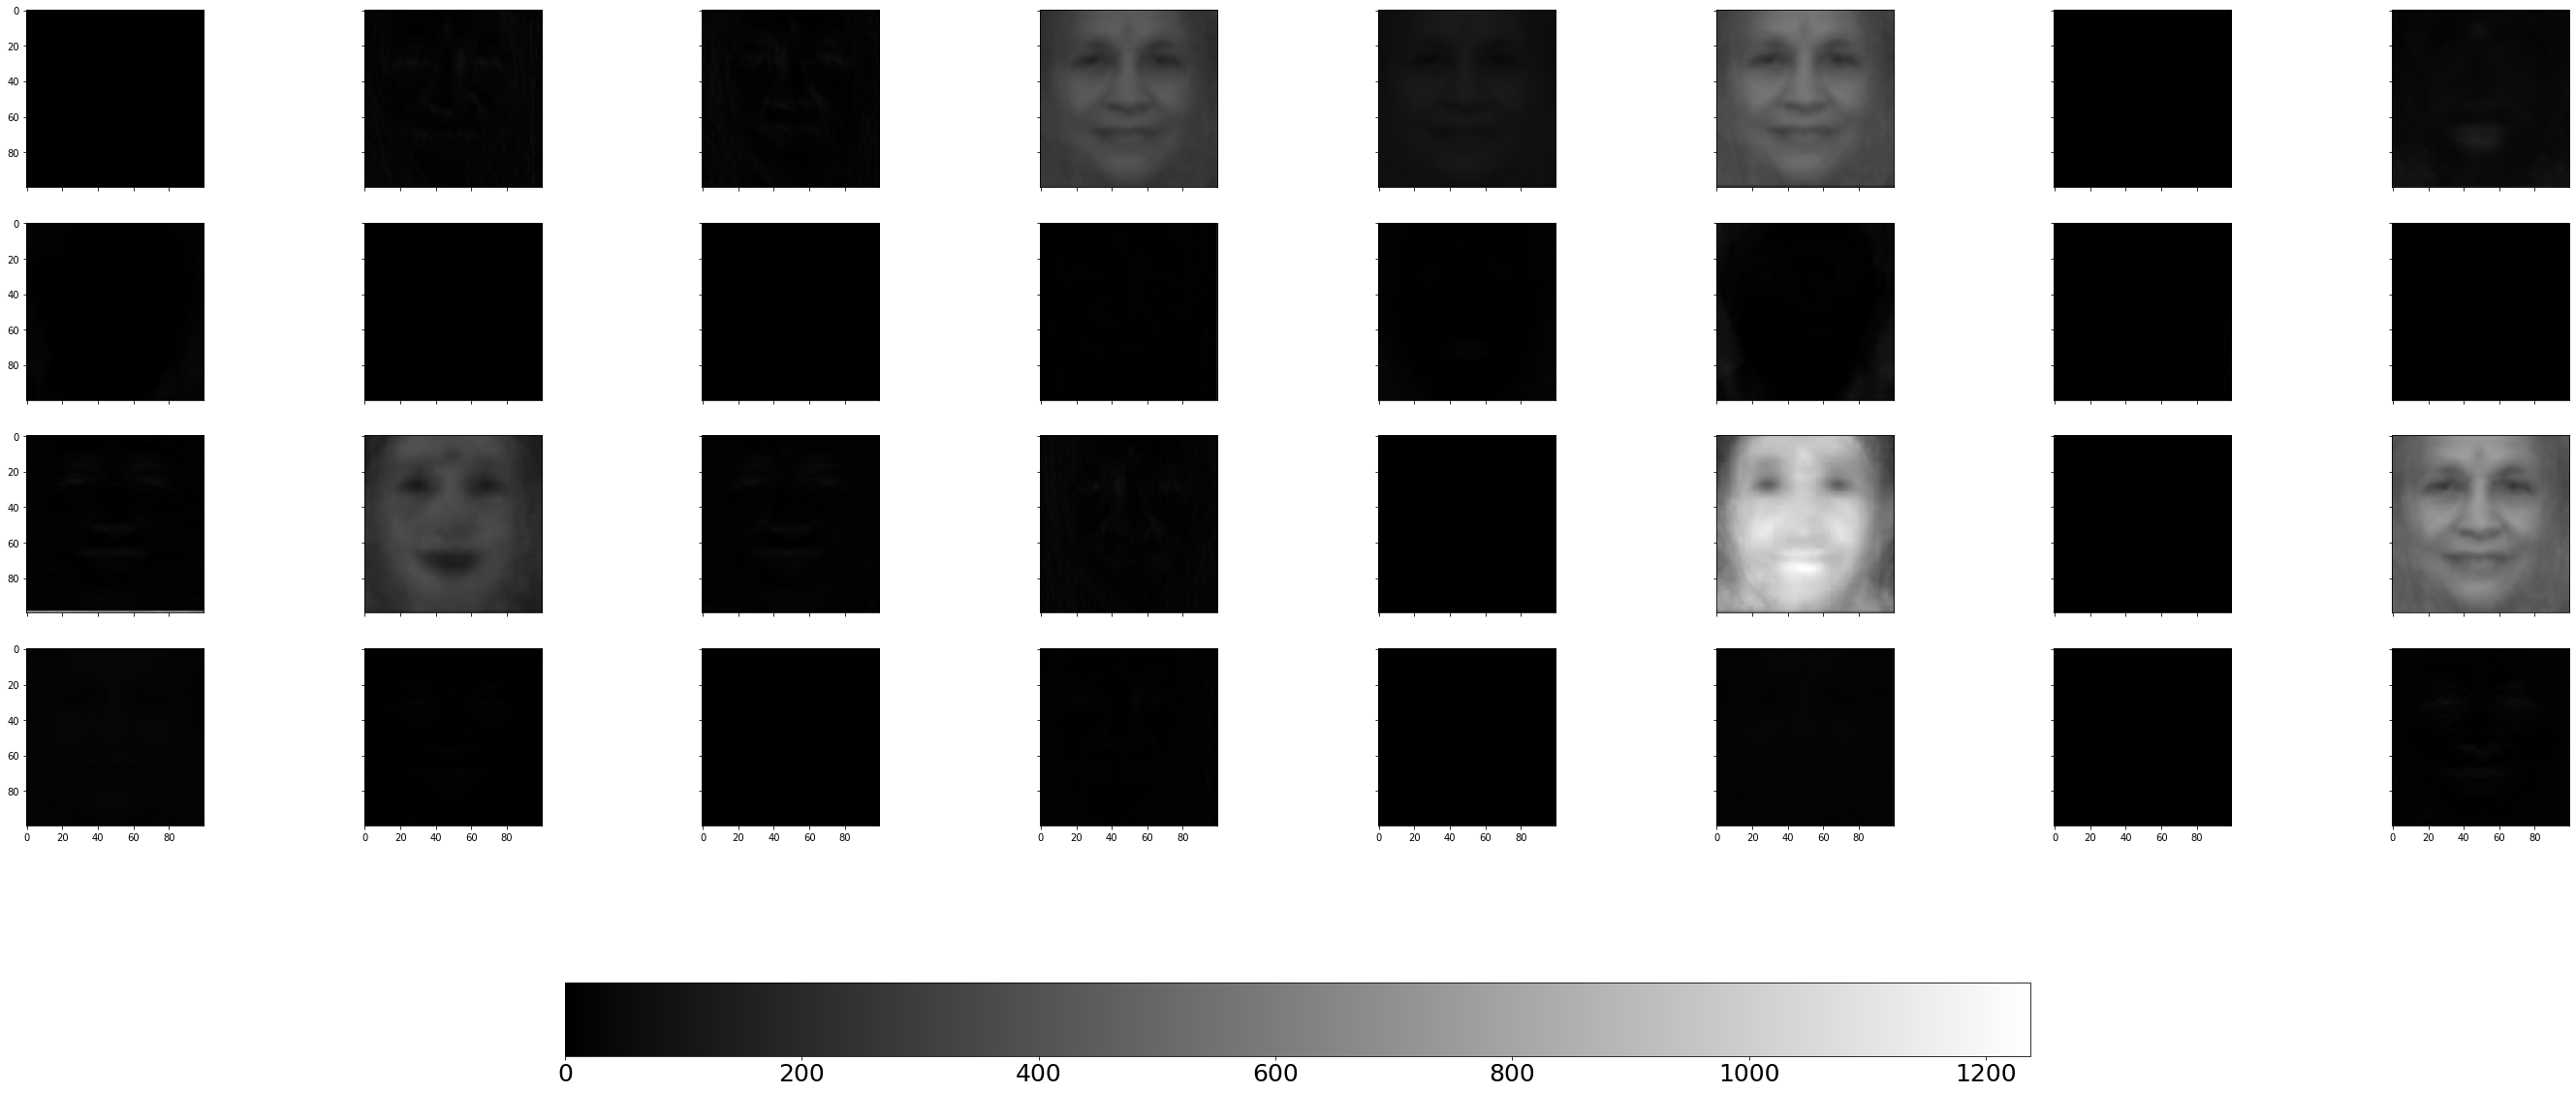

In [22]:
visualization.plot_layer_from_output(preprocessing.output_of_layer_for_multiple_images(layer,model,preprocessing.images_of_a_category('female','indian','old',d)))

On remarque que ce sont les mêmes neurones qui sont activés... <br>
Essayons de récupérer les indices des neurones qui se sont activés. A vue d'oeil, c'est ceux dont les valeurs sont globalement au-dessus de 250.

In [23]:
output_female_indian_old = preprocessing.output_of_layer_for_multiple_images(layer,model,preprocessing.images_of_a_category('female','indian','old',d))

preprocessing.list_kernels_above_value(output_female_indian_old,250)

[3, 5, 17, 21, 23]

Essayons avec une couche plus profonde 

In [24]:
layer = 'block4a_project_conv'

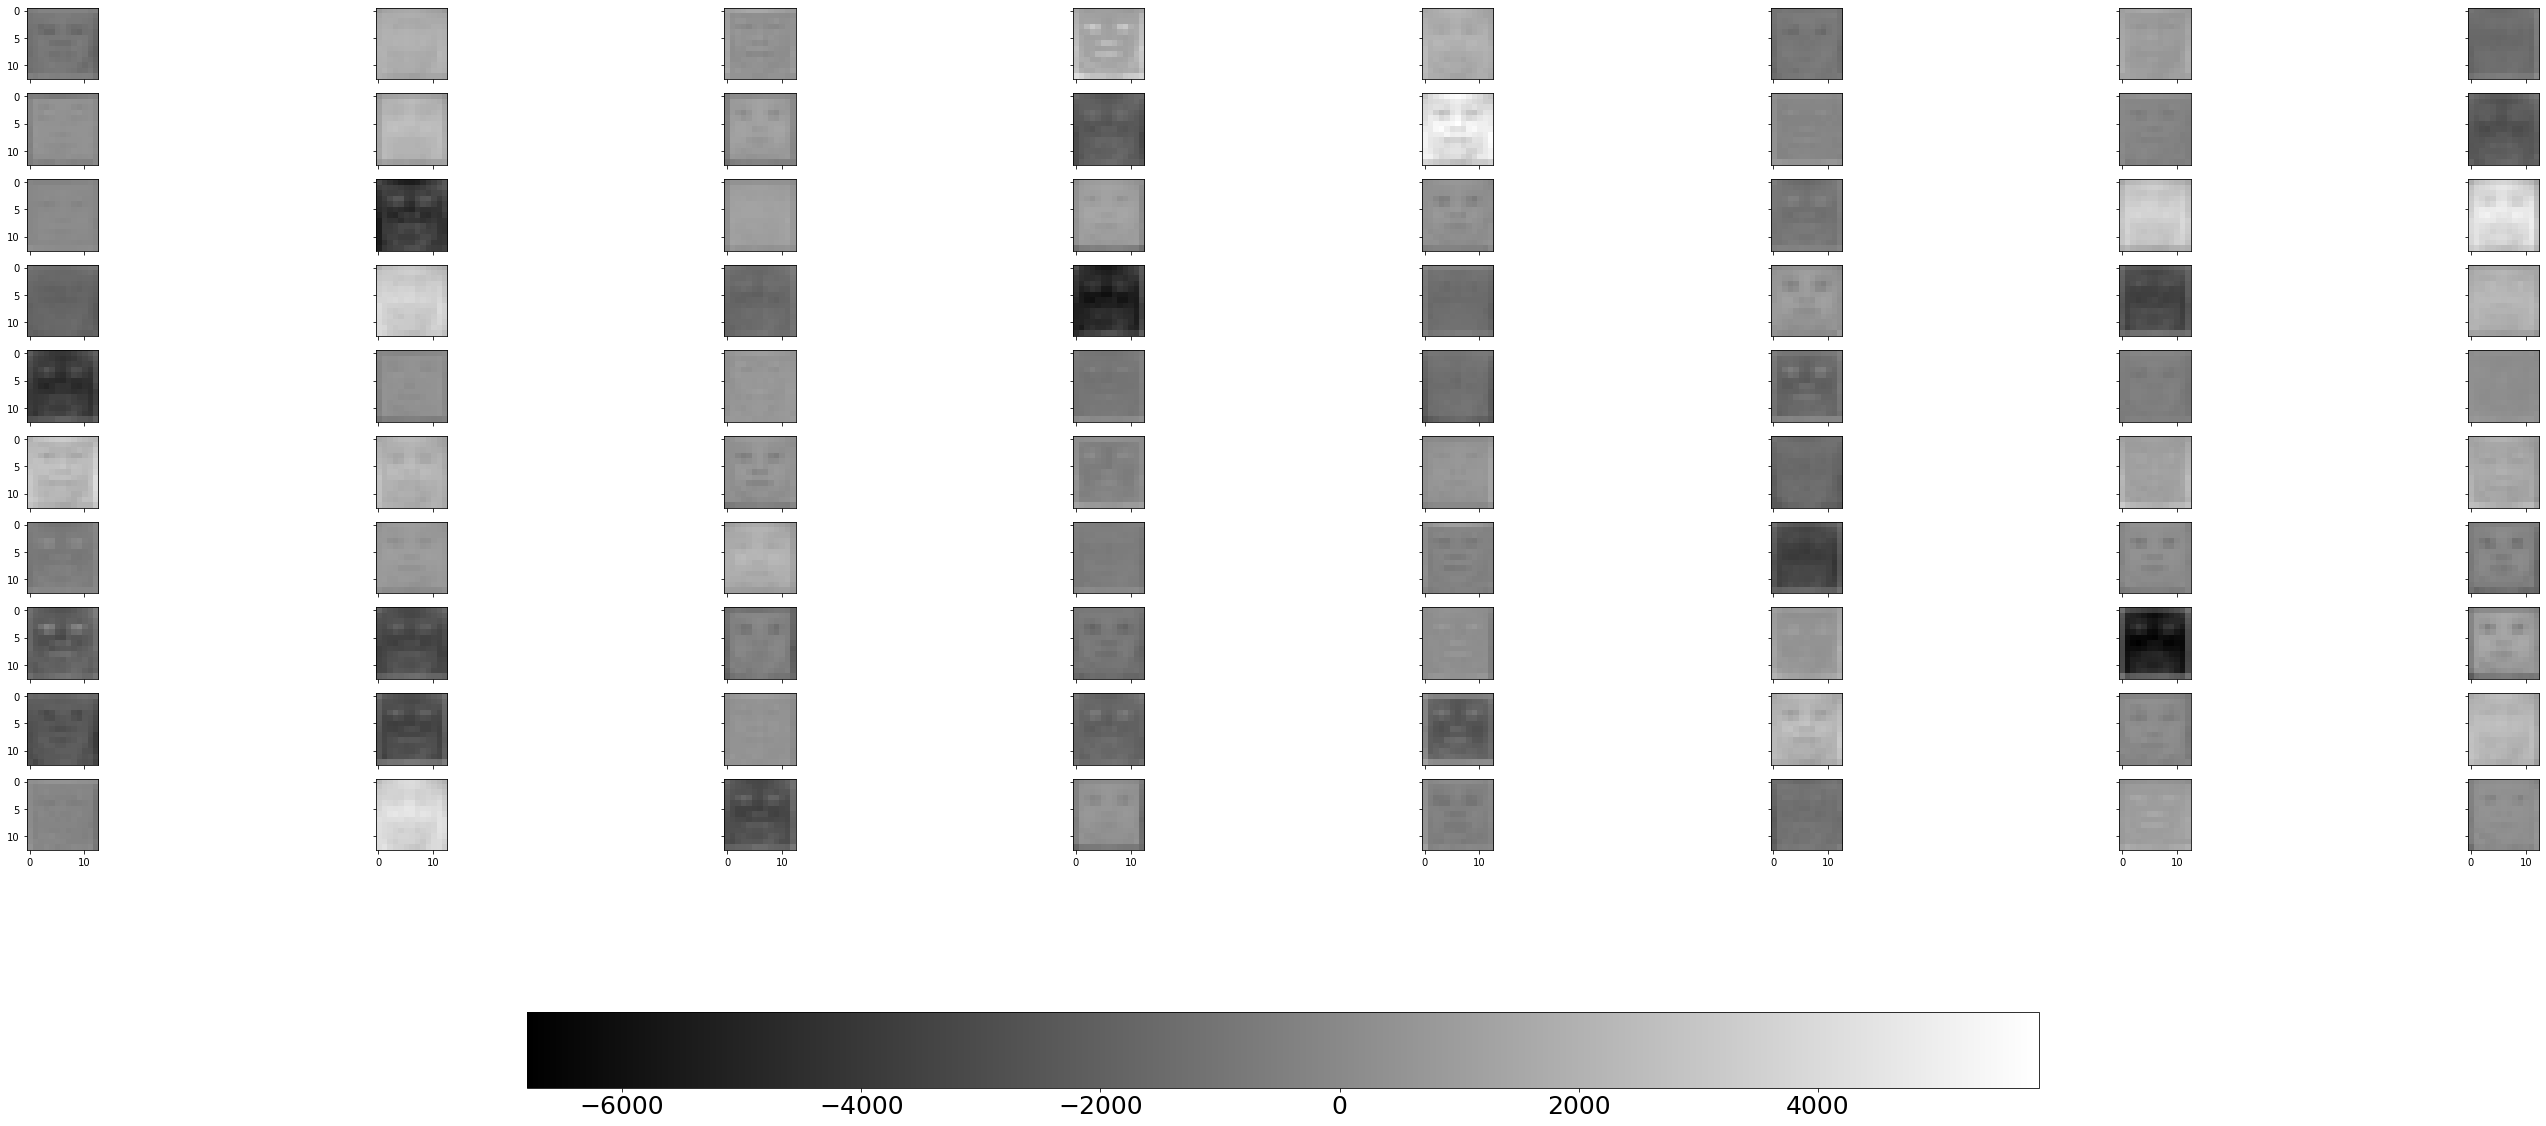

In [25]:
visualization.plot_layer_from_output(preprocessing.output_of_layer_for_multiple_images(layer,model,preprocessing.images_of_a_category('male','black','baby',d)))

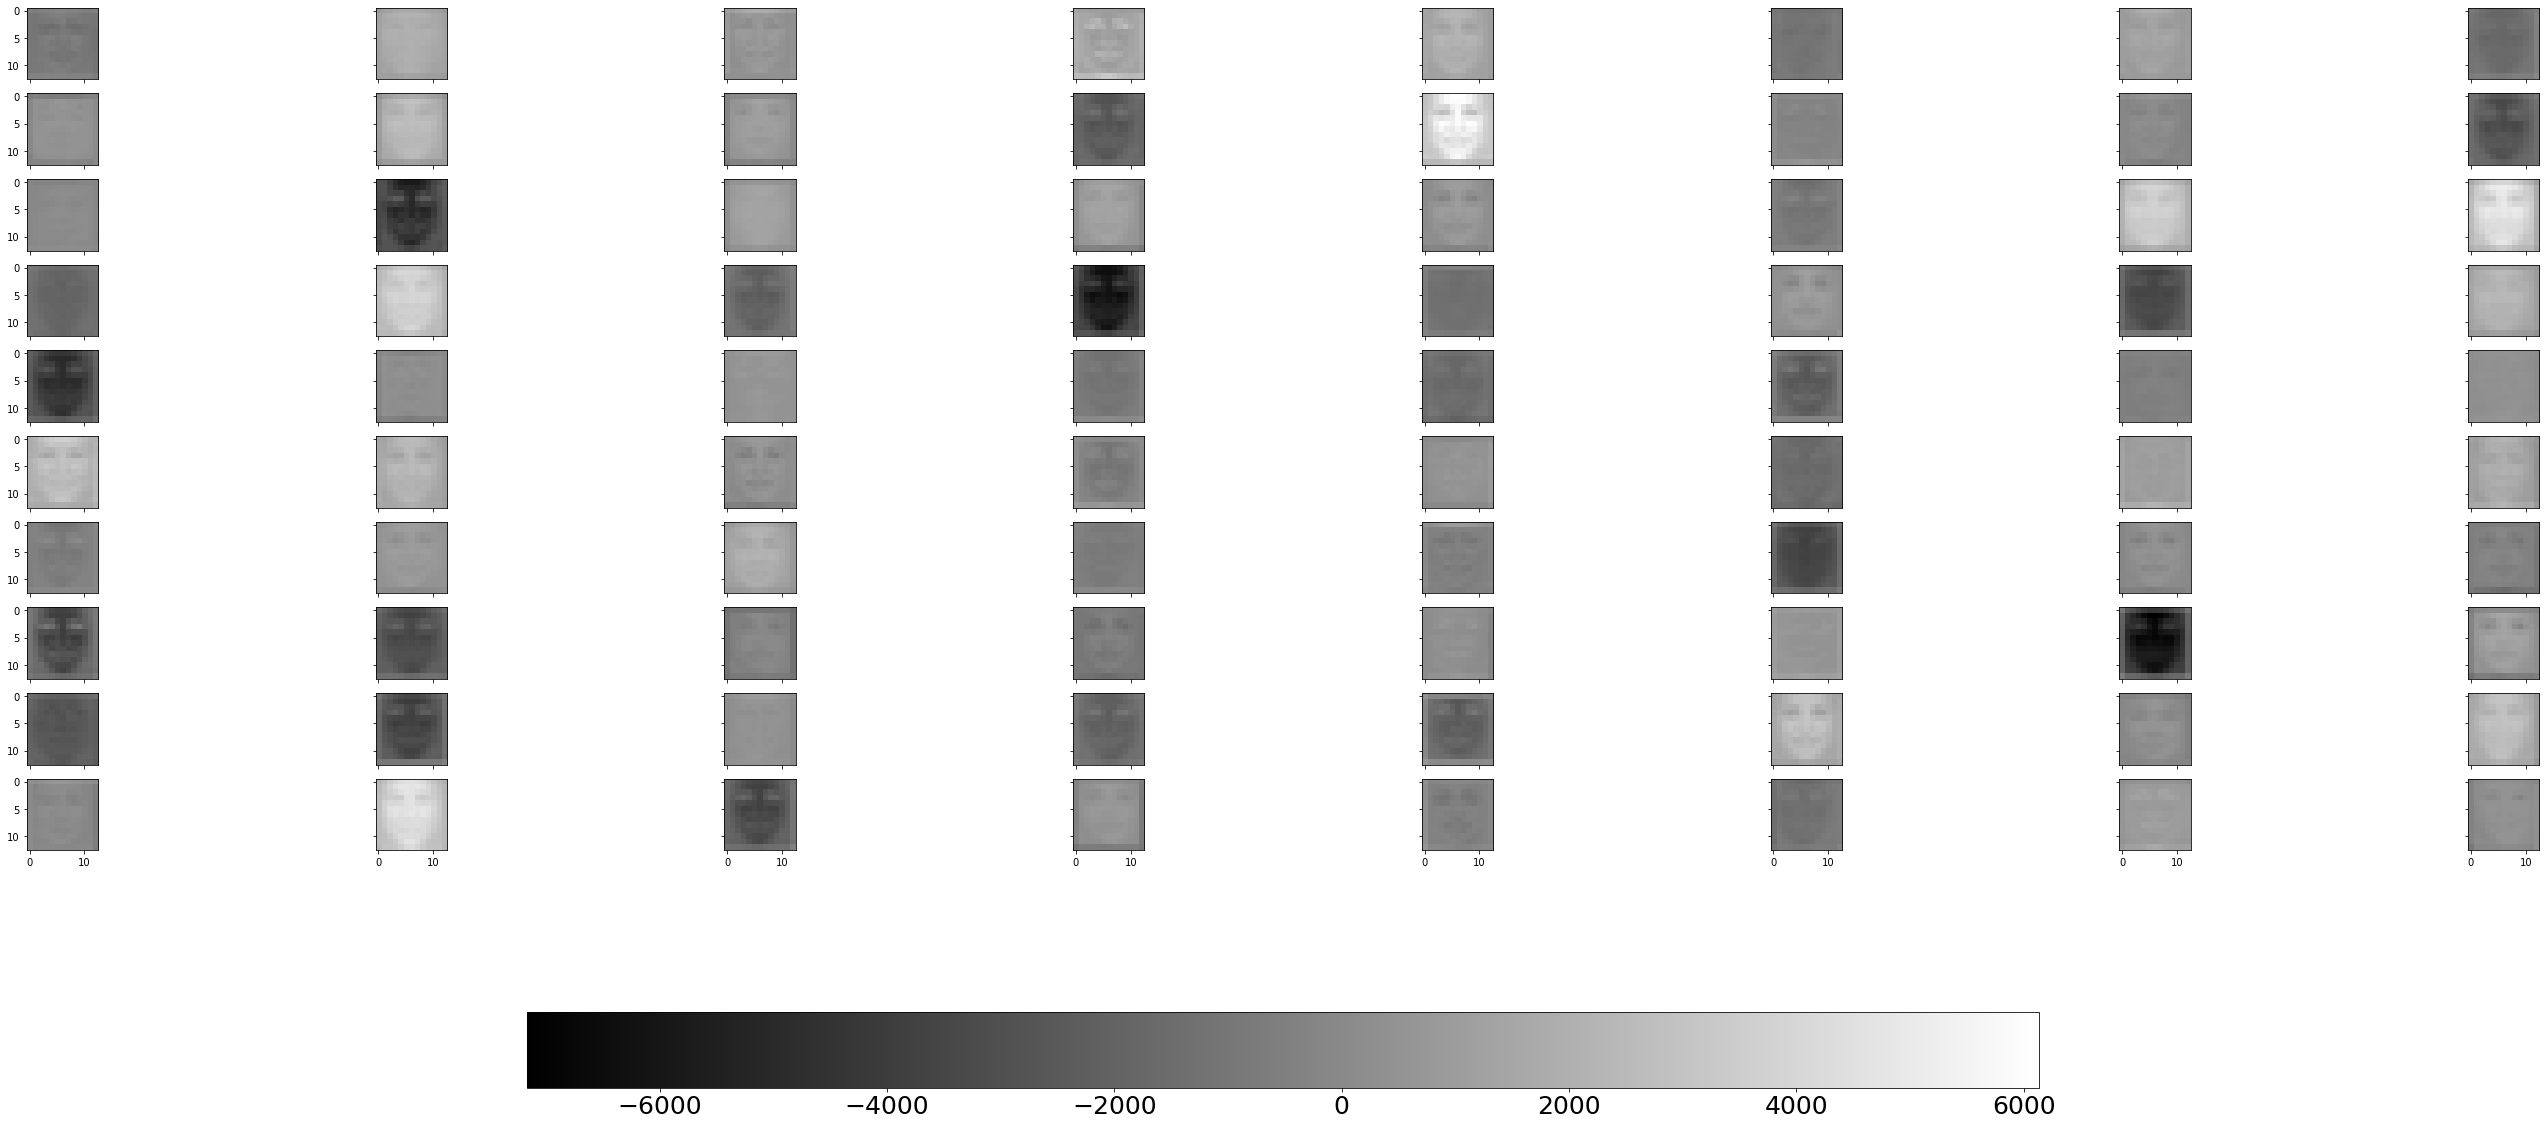

In [26]:
visualization.plot_layer_from_output(preprocessing.output_of_layer_for_multiple_images(layer,model,preprocessing.images_of_a_category('female','white','young',d)))

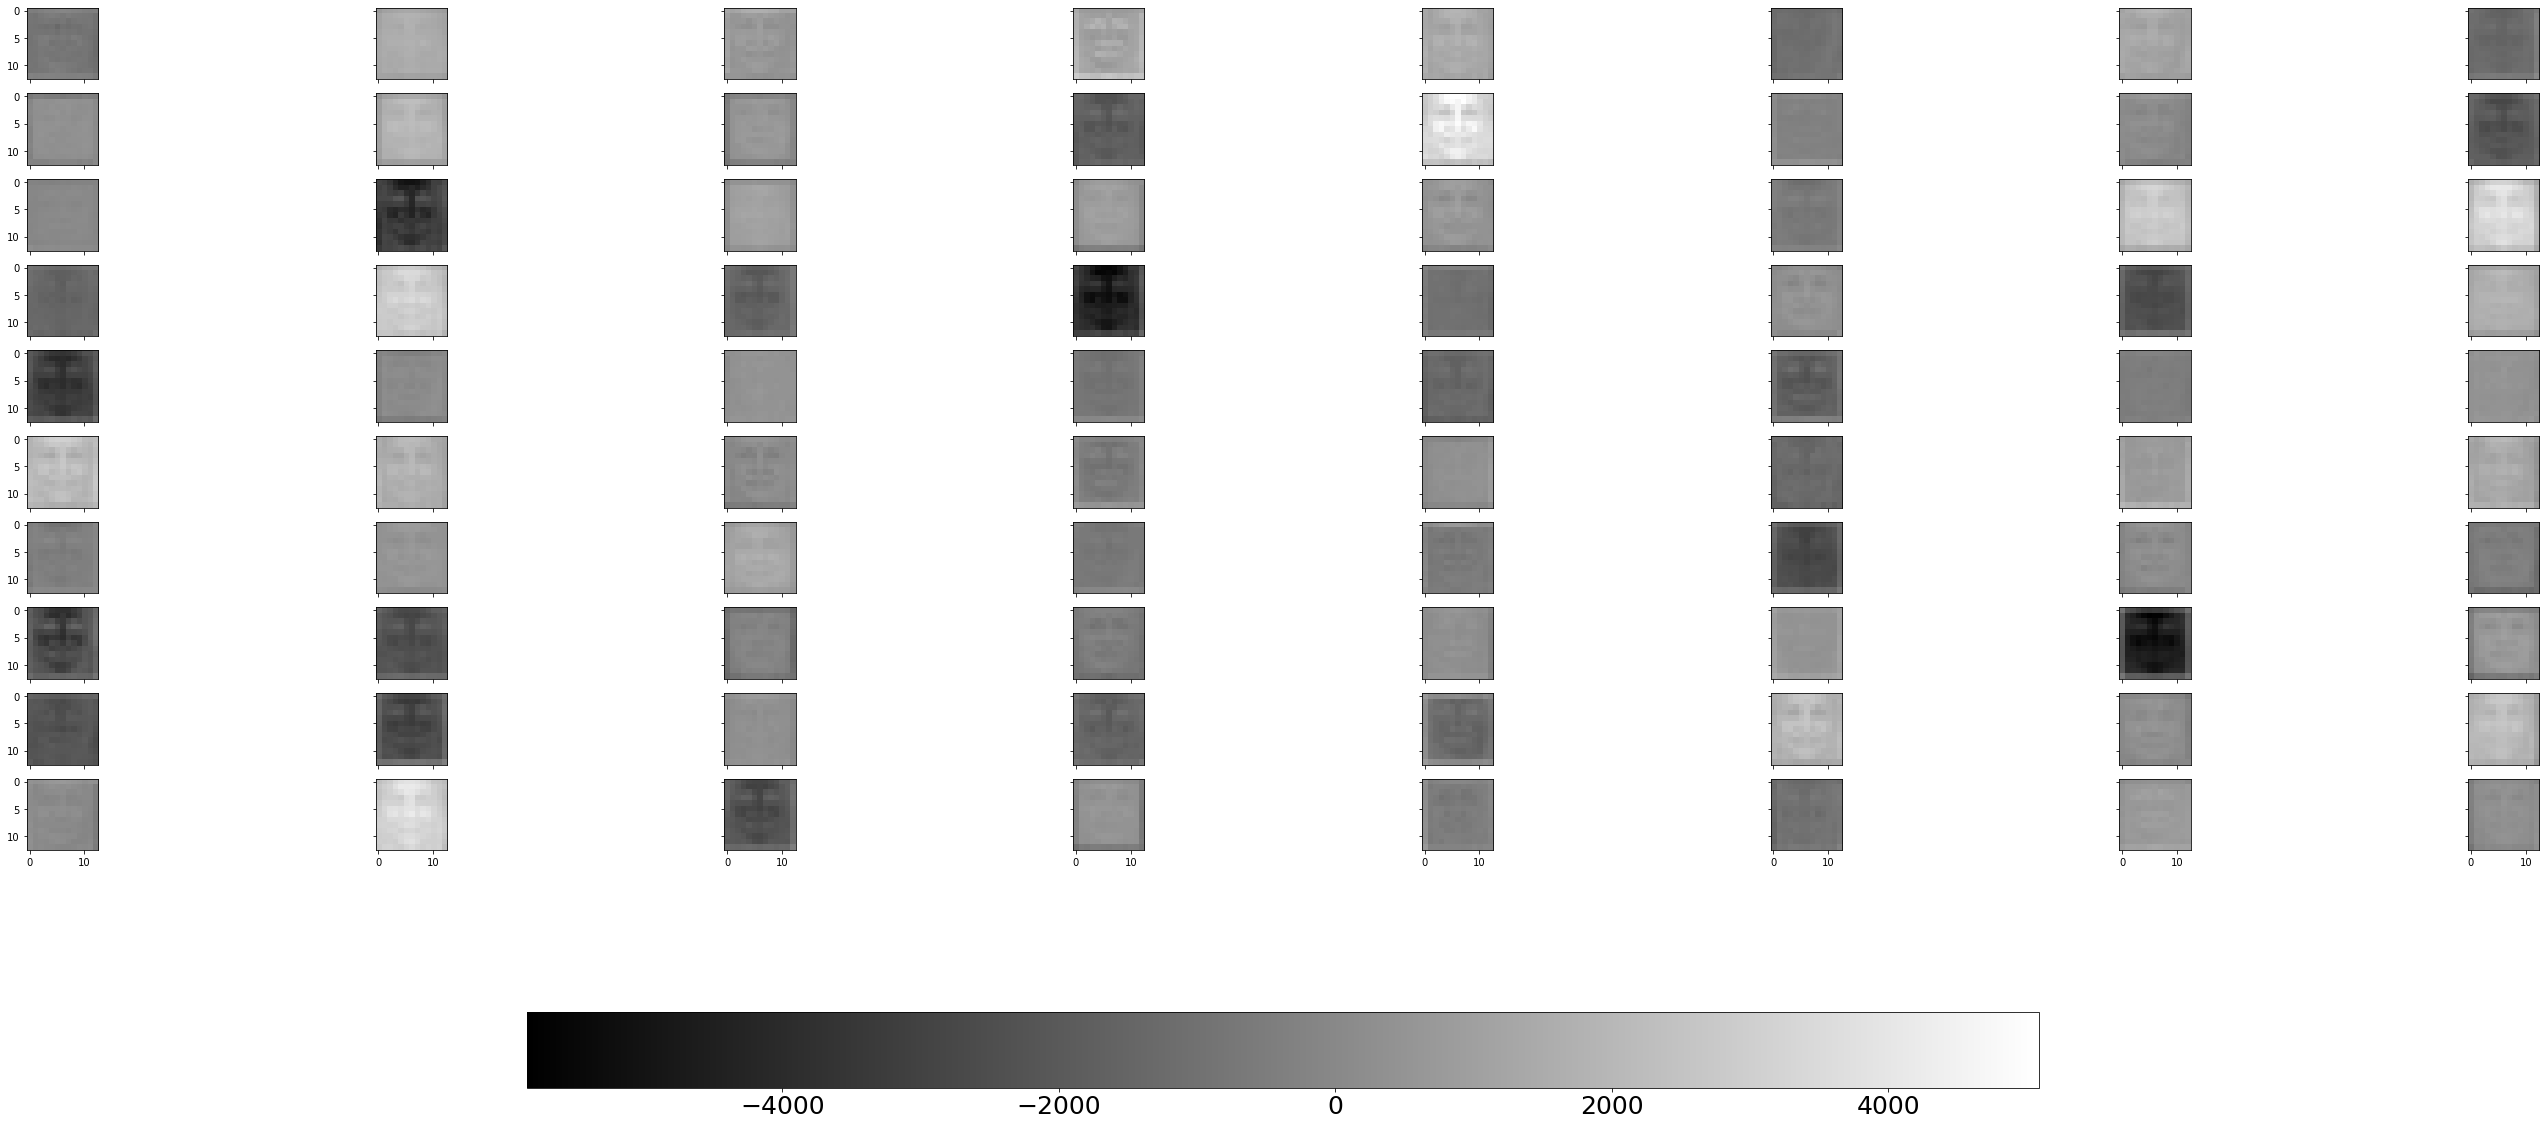

In [27]:
visualization.plot_layer_from_output(preprocessing.output_of_layer_for_multiple_images(layer,model,preprocessing.images_of_a_category('female','indian','old',d)))

ça se ressemble beaucoup 😕